In [1]:
%matplotlib inline

In [2]:
from typing import List
import logging
from typing import Optional
from functools import partial
from typing import Tuple
from typing import Union


import torch.nn as nn
import numpy as np
import os
import pandas as pd
import torch
from torch.optim import Adam
from torchvision.models.resnet import BasicBlock
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet
from sklearn.metrics import roc_auc_score
from torch import Tensor
from torchvision import transforms
from torch.autograd import Variable

In [4]:
DATA_FOLDER = '../../input'
LABELS = f'{DATA_FOLDER}/train_labels.csv'
TRAIN_IMAGES_FOLDER = f'{DATA_FOLDER}/train'
USE_GPU = torch.cuda.is_available()

In [5]:
logging.basicConfig(level='INFO')
logger = logging.getLogger()

In [6]:
def read_labels(path_to_file: str) -> pd.DataFrame:
    labels = pd.read_csv(path_to_file)
    return labels


def format_labels_for_dataset(labels: pd.DataFrame) -> np.array:
    return labels['label'].values.reshape(-1, 1)


def format_path_to_images_for_dataset(labels: pd.DataFrame, path: str) -> List:
    return [os.path.join(path, f'{f}.tif') for f in labels['id'].values]


def train_valid_split(df: pd.DataFrame) -> Tuple:
    limit_df = 50000
    df = df.sample(n = df.shape[0])
    df = df.iloc[:limit_df]
    split = 40000
    train = df.iloc[:split]
    valid = df.iloc[:split]
    return train, valid

### STEP 1 - DATASETS

In [7]:
class MainDataset(Dataset):
    def __init__(self,
                 x_dataset: Dataset,
                 y_dataset: Dataset,
                 x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.x_tfms = x_tfms

    def __len__(self) -> int:
        return self.x_dataset.__len__()

    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        y = self.y_dataset[index]
        if self.x_tfms is not None:
            x = self.x_tfms(x)
        return x, y
    
class ImageDataset(Dataset):
    def __init__(self, paths_to_imgs: List):
        self.paths_to_imgs = paths_to_imgs

    def __len__(self) -> int:
        return len(self.paths_to_imgs)

    def __getitem__(self, index: int) -> Image.Image:
        img = Image.open(self.paths_to_imgs[index])
        return img


class LabelDataset(Dataset):
    def __init__(self, labels: List):
        self.labels = labels

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index: int) -> int:
        return self.labels[index]

In [8]:
labels = read_labels(LABELS)
train, valid = train_valid_split(labels)

train_labels = format_labels_for_dataset(train)
valid_labels = format_labels_for_dataset(valid)

train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)

train_images_dataset = ImageDataset(train_images)
valid_images_dataset = ImageDataset(valid_images)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)

###  STEP 2 - TRANSFORMERS

In [9]:
x_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)

### STEP 3 - DATALOADER

In [11]:
shuffle = True
batch_size = 512
num_workers = 0
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=shuffle, 
                              num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)

### STEP 4 - MODEL

In [12]:
# we will create custom resnet with 9 layers so it can process 96x96 images
def to_gpu(tensor):
    return tensor.cuda() if USE_GPU else tensor


def create_resnet9_model(output_dim: int = 1) -> nn.Module:
    model = ResNet(BasicBlock, [1, 1, 1, 1])
    in_features = model.fc.in_features
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Linear(in_features, output_dim)
    model = to_gpu(model)
    return model

In [13]:
resnet9 = create_resnet9_model(output_dim=1)
resnet9

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### STEP 5 - OPTIMIZER

In [14]:
lr = 1e-3
optimizer = Adam(resnet9.parameters(), lr=lr)

### STEP 6 - LOSS

In [15]:
loss = nn.BCEWithLogitsLoss()

### STEP 7 - TRAINER / PREDICTOR / TRIGGERS

In [16]:
def train_one_epoch(model,
                    train_dataloader,
                    valid_dataloader,
                    loss,
                    optimizer,
                    loss_writer_train,
                    loss_writer_valid,
                    do_step_trigger,
                    valid_loss_trigger,
                    train_loss_trigger,
                    ):
    model.train()
    y_true_train, y_hat_train = [], []
    for iteration, (x, y) in enumerate(train_dataloader):
        x = Variable(T(x), requires_grad=True)
        y = Variable(T(y), requires_grad=True)
        output = model(x)
        y_true_train.append(to_numpy(y))
        y_hat_train.append(to_numpy(output))
        loss_values = loss(output, y)
        loss_values.backward()
        if do_step_trigger(iteration):
            optimizer.step()
            optimizer.zero_grad()
        if train_loss_trigger(iteration):
            auc_writer(y_true_train, y_hat_train, iteration)
            y_true_train, y_hat_train = [], []
        if valid_loss_trigger(iteration):
            y_true, y_hat = predict(model, valid_dataloader)
            auc_writer(y_true, y_hat, iteration)
    return model

In [17]:
def predict(model, dataloader):
    model.eval()
    y_true, y_hat = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = Variable(T(x))
            y = Variable(T(y))
            output = model(x)
            y_true.append(to_numpy(y))
            y_hat.append(to_numpy(output))
    return y_true, y_hat

In [18]:
def iteration_trigger(iteration, every_x_iterations):
    if every_x_iterations == 1:
        return True
    elif iteration > 0 and iteration % every_x_iterations == 0:
        return True
    else:
        return False


def init_triggers(step=1, valid=10, train=10):
    do_step_trigger = partial(iteration_trigger, every_x_iterations=step)
    valid_loss_trigger = partial(iteration_trigger, every_x_iterations=valid)
    train_loss_trigger = partial(iteration_trigger, every_x_iterations=train)
    return do_step_trigger, valid_loss_trigger, train_loss_trigger

In [19]:
def auc_writer(y_true, y_hat, iteration):
    try:
        auc = roc_auc_score(np.vstack(y_true), np.vstack(y_hat))
    except:
        auc = -1
    logger.info(f'iteration: {iteration}, auc: {auc}')

In [20]:
def T(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.FloatTensor(tensor)
    else:
        tensor = tensor.type(torch.FloatTensor)
    if USE_GPU:
        tensor = to_gpu(tensor)
    return tensor


def to_numpy(tensor: Union[Tensor, Image.Image, np.array]) -> np.ndarray:
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError(msg)

In [21]:
loss_writer_train = auc_writer
loss_writer_valid = auc_writer

# backpropagate - every iter
# calculate AUC on valid - every 20 iters 
# AUC on train - every 10 iters
do_step_trigger, valid_loss_trigger, train_loss_trigger = init_triggers(1, 20, 10)

In [22]:
resnet9 = train_one_epoch(
    resnet9,
    train_dataloader,
    valid_dataloader,
    loss,
    optimizer,
    loss_writer_train,
    loss_writer_valid,
    do_step_trigger,
    valid_loss_trigger,
    train_loss_trigger,
)

INFO:root:iteration: 10, auc: 0.7917902628114135
INFO:root:iteration: 20, auc: 0.8778643281423592
INFO:root:iteration: 20, auc: 0.8223438366469057
INFO:root:iteration: 30, auc: 0.6826002789421279
INFO:root:iteration: 40, auc: 0.8235908521591566
INFO:root:iteration: 40, auc: 0.852172167251444
INFO:root:iteration: 50, auc: 0.8547051020891564
INFO:root:iteration: 60, auc: 0.8789491699550327
INFO:root:iteration: 60, auc: 0.8860566551575138
INFO:root:iteration: 70, auc: 0.8744974754782654


### STEP 8 - PREDICTIONS EXTRACTION

In [23]:
y_true, y_hat = predict(resnet9, valid_dataloader)

In [24]:
predictions = pd.DataFrame(
    list(
        zip(
            valid_labels.reshape(-1), 
            np.vstack(y_hat).reshape(-1),
            valid_images
        )
    ), 
     columns=['true', 'pred', 'files'])
predictions.head(3)

true      pred                                              files
0     0 -2.700347  ../../input/train/2c1ce7746f247aeaa0f0fdfe3269...
1     1  2.763641  ../../input/train/26b57e70b71df018895bf92ed165...
2     0 -2.297292  ../../input/train/5f49b4f953b5ef3ec3fc671b8a87...

### STEP 9 - ERRORS ANALYSIS

In [25]:
max_charts = 60
def implot(files, w=2, h=2, cols=12):
    rows = len(files) / cols + 1
    images = [Image.open(f) for f in files]
    plt.figure(figsize = (cols * w, rows * h))
    plt.tight_layout()
    for chart, img in enumerate(images, 1):
        ax = plt.subplot(rows, cols, chart)
        ax.imshow(np.array(img))
        ax.axis('off')

#### FALSE NEGATIVE

<ipython-input-25-0cee15c805e5>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(rows, cols, chart)


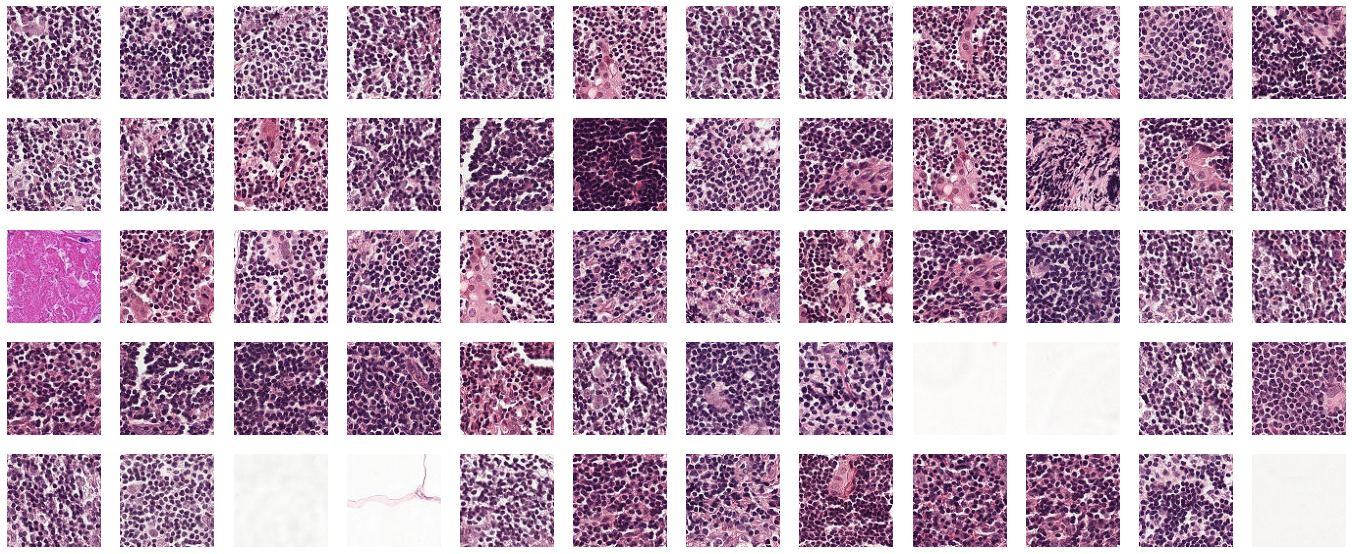

In [26]:
files = predictions[predictions['true']==1].sort_values('pred')['files'].values[:max_charts]
implot(files)

#### FALSE POSITIVE

<ipython-input-25-0cee15c805e5>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(rows, cols, chart)


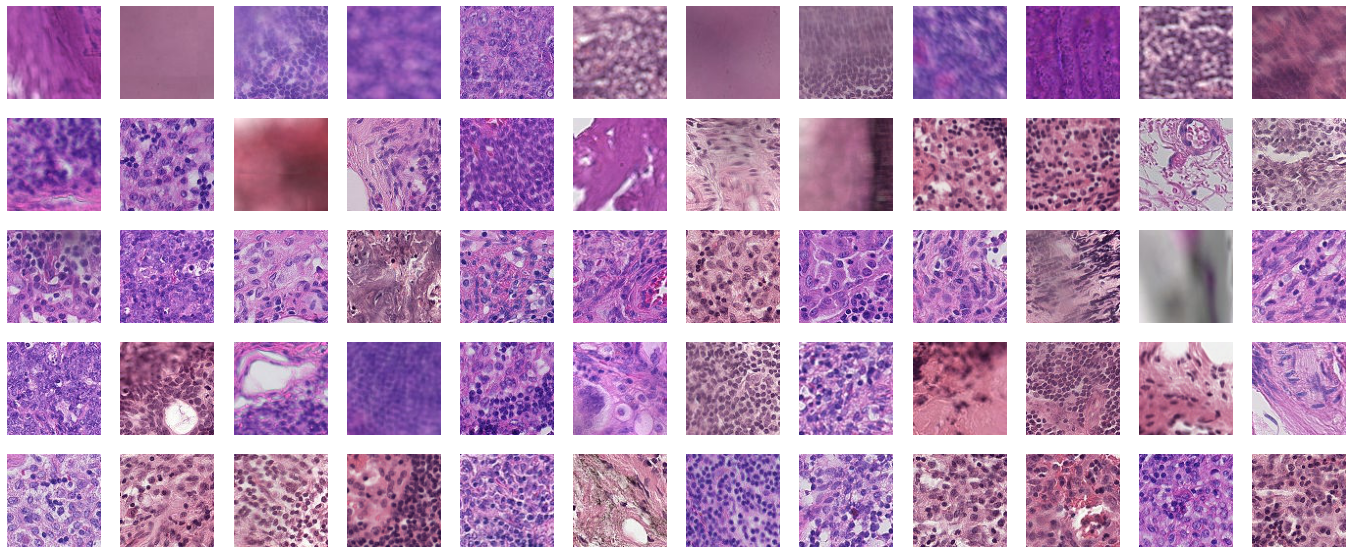

In [27]:
files = predictions[predictions['true']==0].sort_values('pred', ascending=False)['files'].values[:max_charts]
implot(files)

#### TRUE POSITIVE

<ipython-input-25-0cee15c805e5>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(rows, cols, chart)


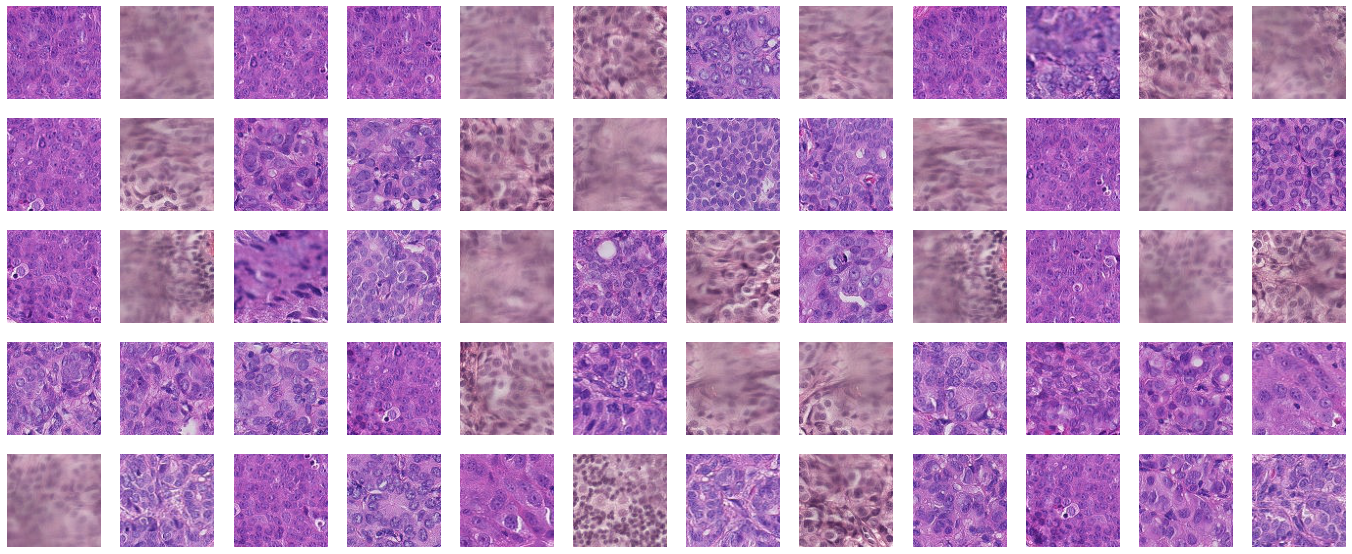

In [28]:
files = predictions[predictions['true']==1].sort_values('pred', ascending=False)['files'].values[:max_charts]
implot(files)

#### TRUE NEGATIVE

<ipython-input-25-0cee15c805e5>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(rows, cols, chart)


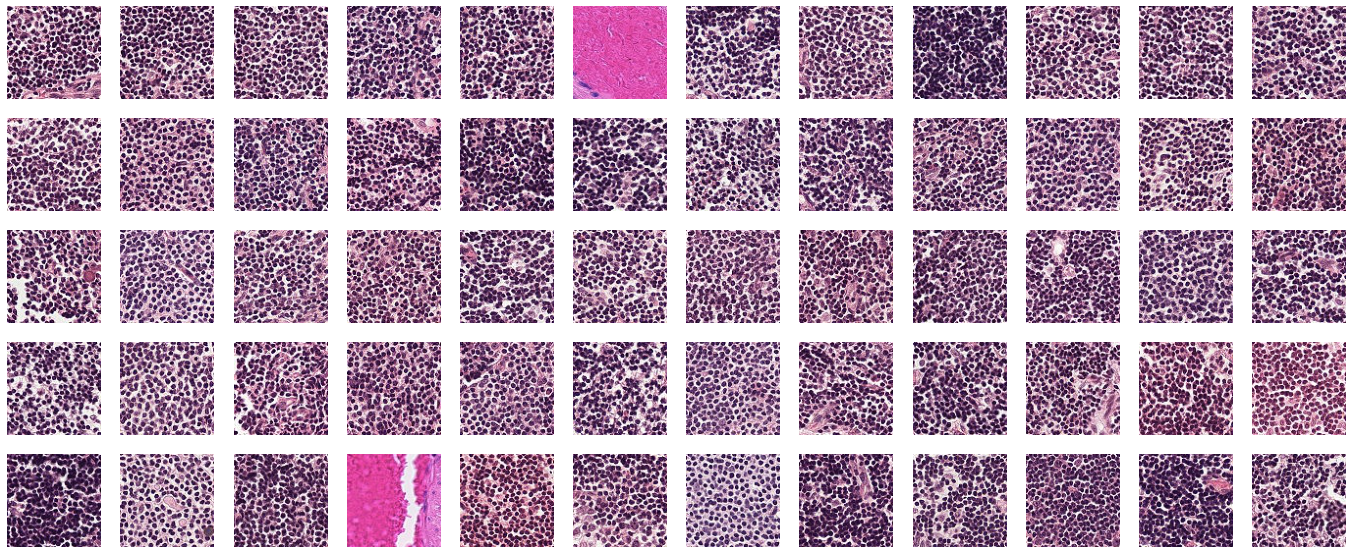

In [29]:
files = predictions[predictions['true']==0].sort_values('pred', ascending=True)['files'].values[:max_charts]
implot(files)